In [1]:
import matplotlib.pyplot as plt
import numpy as np

from gfit.gaussfit import GMM
import gfit.preprocessing as prep

# Generating a sample spectrum (1D gaussian mixture model) with noise and outliers

Data size: 1000
Ratio    : pi = [0.3 0.2 0.5]
Position : mu = [430 460 490]
Variance : v  = [10 40 10]


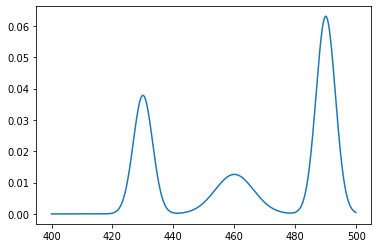

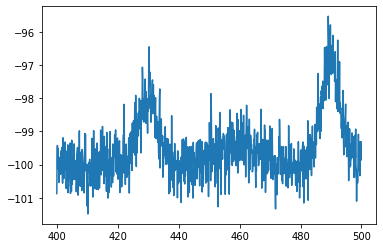

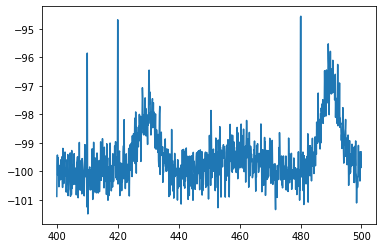

In [2]:
xmin = 400
xmax = 500
dx   = 0.1

x  = np.arange(xmin,xmax,dx)
print(f"Data size: {len(x)}")

pi = np.array([0.3,0.2,0.5])
mu = np.array([430,460,490])
v  = np.array([10,40,10]) 

print(f"Ratio    : pi = {pi}")
print(f"Position : mu = {mu}")
print(f"Variance : v  = {v}")

y = 0
for i in range(len(mu)):
    y += pi[i] / np.sqrt(2*np.pi*v[i]) * np.exp(-0.5/v[i]*(x-mu[i])**2)

plt.plot(x,y)
plt.show()


# --- Scaling, shifting, and adding noise ---
np.random.seed(seed=100)
y *= 50
y += - 100
y += 0.5 * np.random.randn(len(x))

plt.plot(x,y)
plt.show()


# --- Adding outliers ---
y_outlier = np.zeros(len(y)-4)
y_outlier = np.insert(y_outlier,100,5)
y_outlier = np.insert(y_outlier,200,5)
y_outlier = np.insert(y_outlier,800,5)
y_outlier = np.insert(y_outlier,800,5)
 
y += y_outlier
plt.plot(x,y)
plt.show()

# Peak fitting by Gaussian
### Comparison of each method (KM, EM and VB)

=== KM (k-means method)===


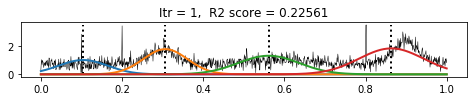

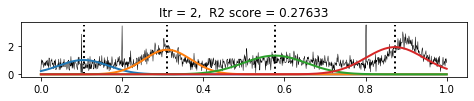

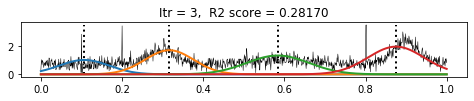

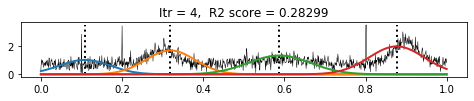

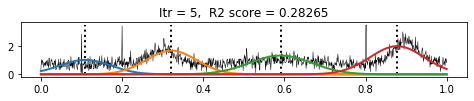

=== EM (EM algorithm)===


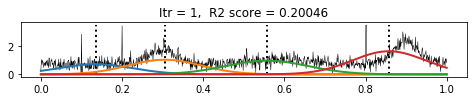

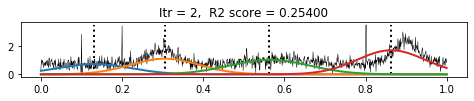

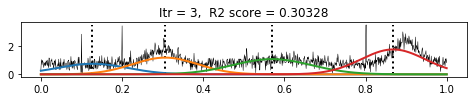

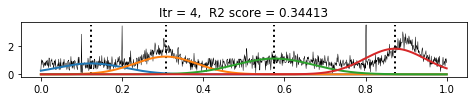

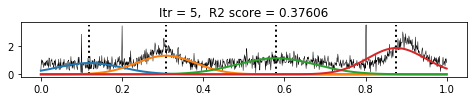

=== VB (Variational Bayes)===


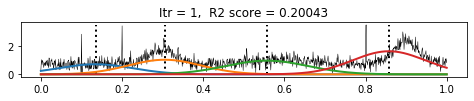

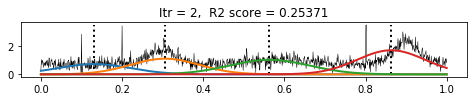

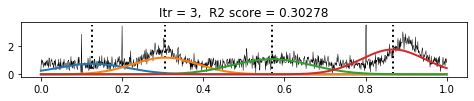

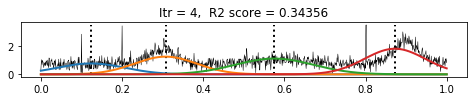

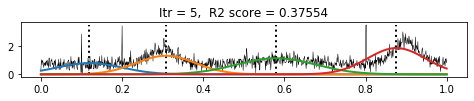

In [3]:
#gmm = GMM(k=4,itr=50,algo='em',seed=None,fig=False,nd=1e6)

# k        : # of Gaussians. It is always better to take one or two more peaks than you can see.
# itr      : # of iterations
# algo="km": k-means method
#      "em": EM algorithm
#      "vb": variational Bayes
# seed     : random seed in numpy
# fig      : plot figure in each itration or not (for progress checking)
# nd       : # of dummy data (used in variational Bayes algorithm)

seed = 101
gmm = GMM(k=4,itr=5,algo="km",seed=seed,fig=True).fit(y)
gmm = GMM(k=4,itr=5,algo="em",seed=seed,fig=True).fit(y)
gmm = GMM(k=4,itr=5,algo="vb",seed=seed,fig=True).fit(y)


### Switching options along the way and displaying the final result.

=== KM (k-means method)===


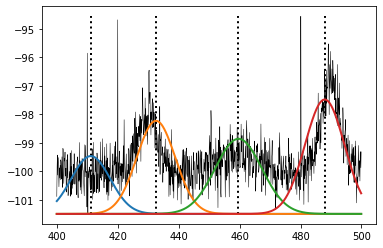

=== EM (EM algorithm)===


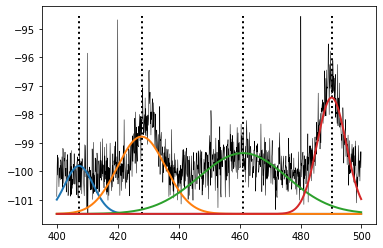


=== Final result ===

Peak ID  Position(mu)   Height  Ratio(pi)  Variance(v)  
      1     407.30207  1.68399    0.09905     21.98194  
      2     427.81212  2.70841    0.26951     62.91786  
      3     461.10467  2.13013    0.38736    210.11604  
      4     490.21427  4.07722    0.24407     22.76961  



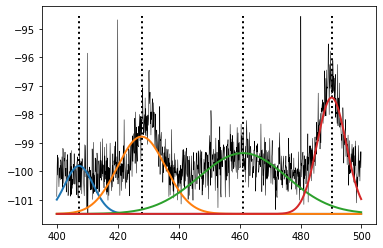

R2 score = 0.50818


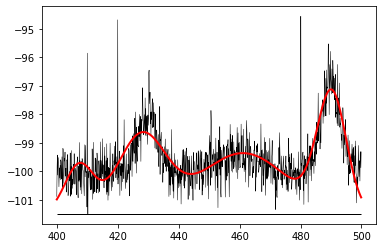

In [4]:
gmm = GMM(k=4,itr=10,seed=101,algo="km").fit(y)
gmm.plot(x,y)
gmm.set_options(itr=100,algo="em").fit(y)
gmm.plot(x,y)


print("\n=== Final result ===\n")
yp = gmm.curve(y)
gmm.plot(x,y,yp)


# Preprocessing
### Preprocessings to remove outliers and reduce noise

Original data
Noise: 0.6315549569925408


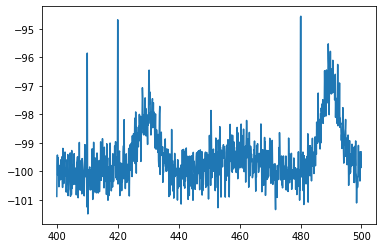

Pooling data (midpoint pooling)
Noise: 0.2348116202322082


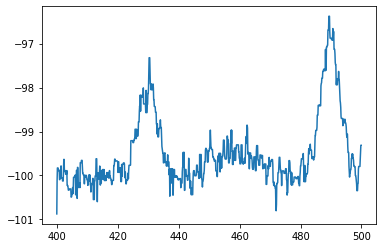

Smoothing data
Noise: 0.16384280678558533


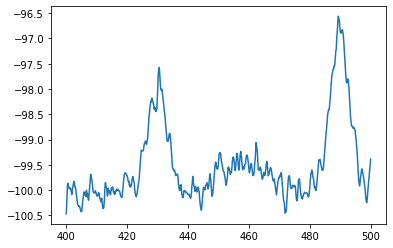

Cutting data
Noise: 0.13829769730774238


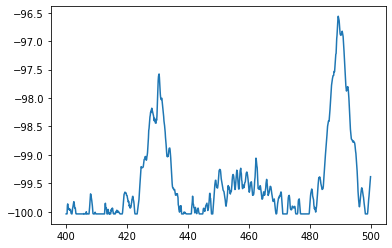

In [5]:
print("Original data")
print(f"Noise: {prep.noise(y)}")
plt.plot(x,y)
plt.show()


y_prep = y.copy()

print("Pooling data (midpoint pooling)")
# The values of p-th neighbors data (2*p+1 candidates) are compared, 
# and only the midpoint value is employed.
# This removes up to p-consecutive outliers.
y_prep = prep.mid_pooling(y_prep,p=3)
print(f"Noise: {prep.noise(y_prep)}")
plt.plot(x,y_prep)
plt.show()


print("Smoothing data")
# Simply the average value of data up to p-th neighbors is taken.
y_prep = prep.smoothing(y_prep,p=3)
print(f"Noise: {prep.noise(y_prep)}")
plt.plot(x,y_prep)
#plt.hlines(prep.base(y_prep),min(x),max(x))
plt.show()


print("Cutting data")
# Data below a baseline (automatically given) are trimmed to the values of the baseline.
y_prep = prep.above(y_prep)
print(f"Noise: {prep.noise(y_prep)}")
plt.plot(x,y_prep)
plt.show()


### Improvement of fitting accuracy by the preprocessings

=== KM (k-means method)===
=== EM (EM algorithm)===
Final result
Peak ID  Position(mu)   Height  Ratio(pi)  Variance(v)  
      1     418.83663  0.09196    0.04028     93.93105  
      2     429.93652  2.05462    0.28154      9.19276  
      3     458.66438  0.61437    0.21242     58.52839  
      4     489.78933  2.94377    0.46575     12.25517  



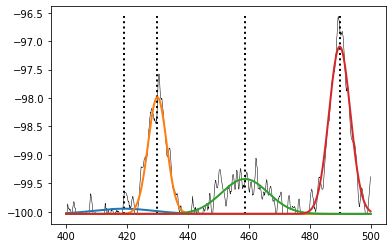

R2 score = 0.95624


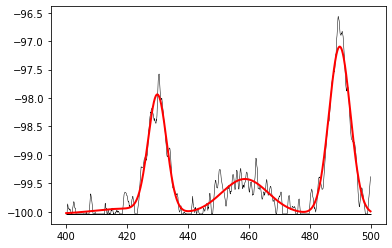

R2 score = 0.60206


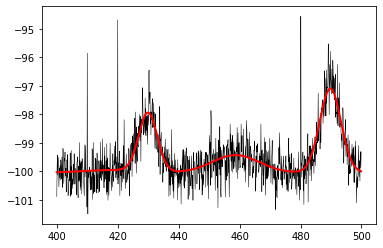

In [6]:
gmm = GMM(k=4,itr=10,seed=101,algo="km").fit(y_prep)
gmm.set_options(itr=50,algo="em").fit(y_prep)

print("Final result")
yp = gmm.curve(y_prep)
gmm.plot(x,y_prep,yp)

score = gmm.score(y,yp)
print(f"R2 score = {score:.5f}")
plt.plot(x,y,color="k",lw=0.5)
plt.plot(x,yp,color="r",lw=2)
plt.show()

# Peak extraction
### Take only the peak positions of Gaussians with large height above noise (the height is proportional to ratio/variance).

In [7]:
# get parameters for original data scale.
pi,mu,v,h = gmm.params(x,y_prep)
print(f"Ratio    : pi = {pi}")
print(f"Position : mu = {mu}")
print(f"Variance : v  = {v}")
print(f"Height   : h  = {h}")
print()


# Peaks are extracted based on the height of the peak 
# relative to the volume of noise in the origiral data.

print(f"Noise = {prep.noise(y)}")
peaks = prep.peak_extraction(y,mu,h)

print(f"The positions of peaks with a significant height:")
print(f"{peaks}")

Ratio    : pi = [0.040281   0.28154353 0.21242479 0.46575068]
Position : mu = [418.8366326  429.9365155  458.66438235 489.78933056]
Variance : v  = [93.9310549   9.19276395 58.52838639 12.25516897]
Height   : h  = [0.09196127 2.05462134 0.61437171 2.94376505]

Noise = 0.6315549569925408
The positions of peaks with a significant height:
[429.9365155  458.66438235 489.78933056]
